# Importacion de librerias

In [3]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import plotly.offline as py
import numpy as np
import seaborn as sns
import datetime as dt
import cufflinks as cf
from IPython.display import display, HTML
from sodapy import Socrata
import streamlit as st

cf.set_config_file(sharing='public', theme='ggplot', offline=True)

pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

________
# Campo de funciones

Con está función llamamos un data set para normalizar los nombre de los estados, ya que se encuentrán en código

In [4]:
def nom_est():
        #nombre de los estados
    nam = pd.read_html('https://es.wikipedia.org/wiki/Estado_de_los_Estados_Unidos')[1]
    nam = nam[['Abrev.','Estado']]
    nam.rename(columns={'Abrev.':'state', 'Estado':'state_name'}, inplace=True)
    return nam

Cargamos la data y normalizamos y implementamos los nombre según su código

In [5]:
def cargadata():
    #descarga de datos y limpieza
    df = pd.read_csv('D:\Proyectos\DS-PI-ProyectoIndividual\data\COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_State_Timeseries.csv')
    df = pd.merge(df, nom_est()[['state', 'state_name']], on=['state'], how='left')
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(['date'])
    df['Year']  = pd.DatetimeIndex(df['date']).year
    df.reset_index(drop=True, inplace=True)
    
    return df

______
# importación de datos

In [6]:
nam = nom_est()
df = cargadata()

C:\Users\Admin\AppData\Local\Temp\ipykernel_1668\3184116154.py:7: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`



____
##### 1 - ¿Cuáles fueron los 5 Estados con mayor ocupación hospitalaria por COVID? Criterio de ocupación por cama común. Considere la cantidad de camas ocupadas con pacientes confirmados y tome como referencia los 6 primeros meses del 2020 - recuerde incluir la cifra de infectados en esos meses (acumulativo). ¿Influye el rango etario en este comportamiento?

los rango rangos estarios se implementaron en el 30/04/2021

In [7]:
df01 = df.loc[:,['state', 'date', 'inpatient_beds', 'inpatient_beds_used_covid', ]]
df01 = df01.loc[(df01['date'] >= '2020-01-01') & (df01['date'] <= '2020-06-30')]

In [8]:
df01.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6694 entries, 0 to 6693
Data columns (total 4 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   state                      6694 non-null   object        
 1   date                       6694 non-null   datetime64[ns]
 2   inpatient_beds             6689 non-null   float64       
 3   inpatient_beds_used_covid  6610 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 261.5+ KB


In [9]:
df01.isna().sum()

state                         0
date                          0
inpatient_beds                5
inpatient_beds_used_covid    84
dtype: int64

In [10]:
df01 = df01[df01['inpatient_beds'].notna()] 
df01 = df01.fillna(0) #remplazo nan

Obtenemos los datos a usar, realizamos el check de los datos y eliminamos los nulos 'inpatien_beds' y remplazamos los NAN, por la cantidad de nulos que teniamos
______

In [11]:
df01['Percentege_bed_used'] = df01['inpatient_beds_used_covid'] / df01['inpatient_beds'] #obtuve porcentaje de camas usadas
df01.head(3)

,state,date,inpatient_beds,inpatient_beds_used_covid,Percentege_bed_used
0,NC,2020-01-01,72.0,0.0,0.0
1,HI,2020-01-01,0.0,0.0,NaN
2,PR,2020-01-01,146.0,0.0,0.0


In [12]:
# Realice un agrupamiento por la media de ocupacion hospitalaria en los estados
df01 = df01.groupby('state')['Percentege_bed_used'].mean()
df01 = df01.reset_index()
df01['Percentege_bed_used'] = df01['Percentege_bed_used'].apply(lambda x: x * 100) #con la función lambda lo pasamos a formato porcentaje 

In [13]:
col = ['state', 'Percentege_bed_used']
top05 = df01.nlargest(5, 'Percentege_bed_used')[col] #con esta funcion obtengo los 5 estados con media mas alta
top05 = pd.merge(top05, nam[['state', 'state_name']], on=['state'], how='left') #normalizo el nombre con el codigo
first_column = top05.pop('state_name')   #obtengo la columna a mover
top05.insert(0, 'state_name', first_column) #se coloca la columa a primera posicion
top05.set_index('state', inplace=True)

In [14]:
df01 = df01.sort_values('Percentege_bed_used', ascending=False) #ordenamos los valores para graficar uniformenete

In [15]:
top05

,state_name,Percentege_bed_used
state,,
NY,Nueva York[19]​,21.347304
NJ,Nueva Jersey[17]​,20.240464
MA,Massachusetts,17.767949
CT,Connecticut,14.550693
LA,Luisiana[10]​,13.784827


In [16]:
top05.to_markdown()

'| state   | state_name       |   Percentege_bed_used |\n|:--------|:-----------------|----------------------:|\n| NY      | Nueva York[19]\u200b   |               21.3473 |\n| NJ      | Nueva Jersey[17]\u200b |               20.2405 |\n| MA      | Massachusetts    |               17.7679 |\n| CT      | Connecticut      |               14.5507 |\n| LA      | Luisiana[10]\u200b     |               13.7848 |'

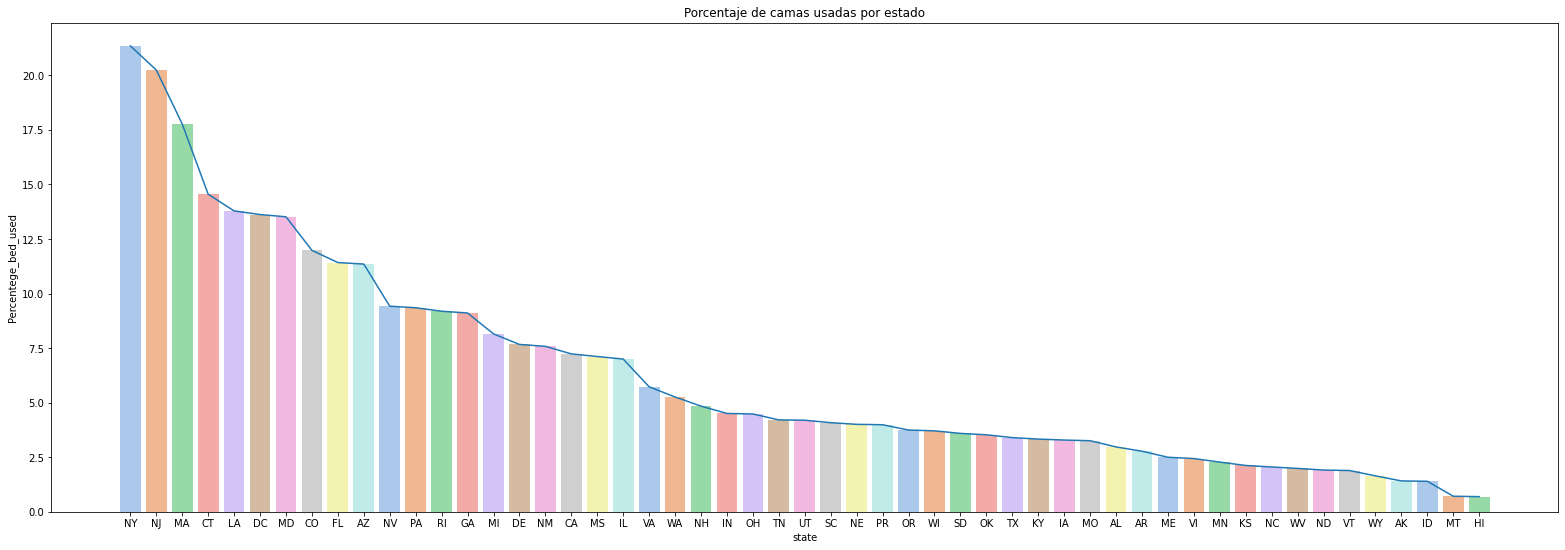

Los 5 estados con mayor ocupación hospitalaria por COVID: 
               state_name  Percentege_bed_used
state                                        
NY       Nueva York[19]​            21.347304
NJ     Nueva Jersey[17]​            20.240464
MA         Massachusetts            17.767949
CT           Connecticut            14.550693
LA         Luisiana[10]​            13.784827


In [92]:
plt.figure(figsize=(27,9))
ax = sns.barplot(data=df01, x="state", y="Percentege_bed_used", palette='pastel')
plt.plot(df01.state,df01['Percentege_bed_used'])
plt.title('Porcentaje de camas usadas por estado')
plt.show()
print('Los 5 estados con mayor ocupación hospitalaria por COVID: \n' , top05 )

In [56]:
import plotly.express as px

fig = px.bar(df01, x=df01.state, y=df01['Percentege_bed_used'])
fig.show()